# Solution: Frequentist Model Fitting Breakout

Following is an example solution to the [Model Fitting Breakout](01.2-Model-Fitting-Breakout.ipynb).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# use seaborn plotting defaults
# If this causes an error, you can comment it out.
import seaborn as sns
sns.set()

## Part I: Fourier Fit to RR Lyrae

In [2]:
from fig_code import sample_light_curve
t, y, dy = sample_light_curve()

Visualize the data:

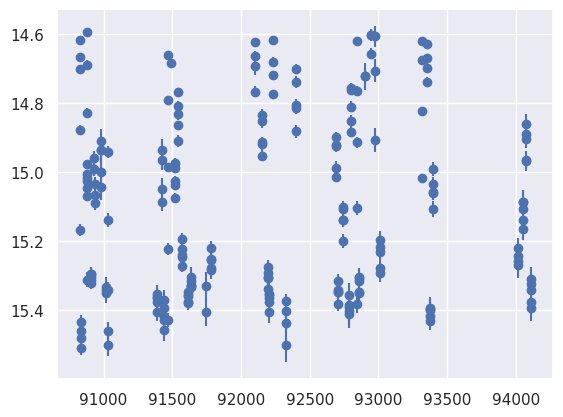

In [3]:
plt.errorbar(t, y, dy, fmt='o')
plt.gca().invert_yaxis();

This data has already been phased, so if we just take the fractional part of *t* then we can see the folded light curve

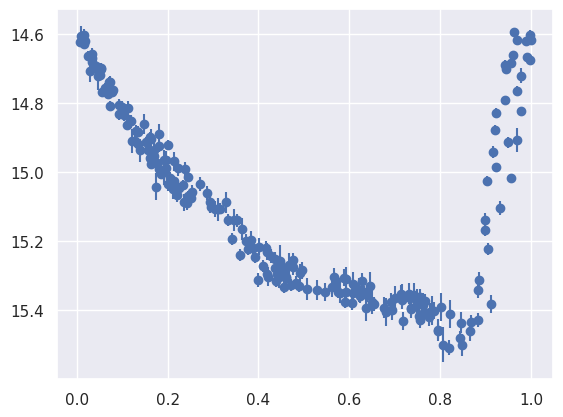

In [4]:
plt.errorbar(t % 1, y, dy, fmt='o')
plt.gca().invert_yaxis();

### 1. Iterative Solution

We'll start with an iterative solution to the problem.

1. Create a function which evaluates the model given an array of times *t*, a base frequency $\omega$, and an array of coefficients $\theta$.  **For this section, we will not treat $\omega$ as a model parameter, but as a constant.** For your model, you can use $\omega = 2\pi$ (we'll relax this assumption in part II).

2. Create a function which evaluates the log-likelihood as a function of $\theta$, using the above function.  **Keep in mind that ``theta`` must be a one-dimensional array (this is what ``optimize.fmin()`` requires)**

3. Use ``scipy.optimize.fmin`` to maximize your log-likelihood (i.e. minimize the negative log-likelihood) to find the optimal model.

4. Plot this model over the data to see how it looks.

5. Use new data, from ``fig_code.sample_light_curve_2()``, and apply your code again (hopefully you've written the functions so that they can easily be reused, right?

In [5]:
# Part 1:
def model(theta, t, omega=2*np.pi):
    return (theta[0] +
            theta[1] * np.sin(omega * t) + theta[2] * np.cos(omega * t) +
            theta[3] * np.sin(2 * omega * t) + theta[4] * np.cos(2 * omega * t))

In [6]:
# Part 2:
def log_likelihood(theta, t, y, dy, omega=2*np.pi):
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         ((y - model(theta, t, omega)) / dy) ** 2)

In [7]:
# Part 3:
from scipy import optimize

# fmin minimizes, not maximizes, a function: use the negative log-likelihood
def neg_log_likelihood(theta, t, y, dy):
    return - log_likelihood(theta, t, y, dy)

theta_guess = [0, 1, 1, 1, 1]
theta_fit = optimize.fmin(neg_log_likelihood, theta_guess, args=(t, y, dy))

Optimization terminated successfully.
         Current function value: 2478.505453
         Iterations: 482
         Function evaluations: 781


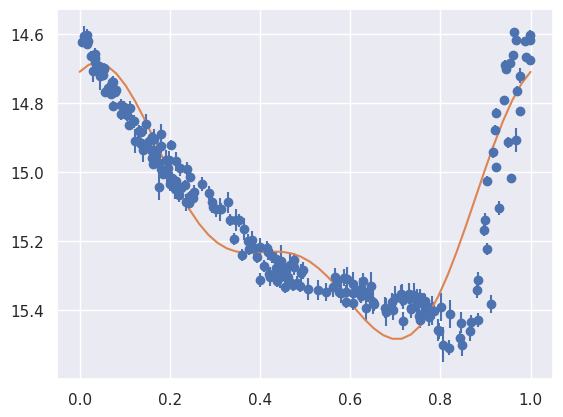

In [8]:
# Part 4:

# We'll plot the phased data for clarity
phase_fit = np.linspace(0, 1)
plt.errorbar(t % 1, y, dy, fmt='o')
plt.plot(phase_fit, model(theta_fit, phase_fit));
plt.gca().invert_yaxis()

Optimization terminated successfully.
         Current function value: 8062.414006
         Iterations: 392
         Function evaluations: 634


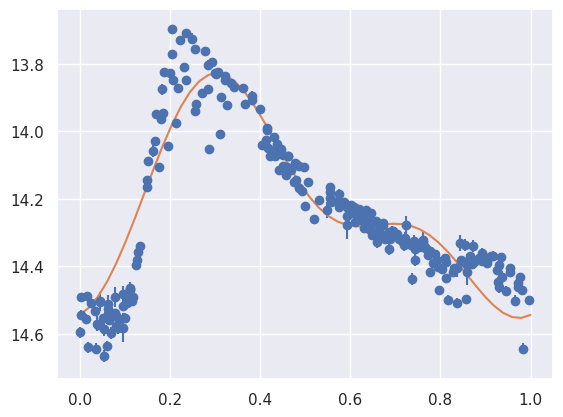

In [9]:
# Part 5:

from fig_code import sample_light_curve_2
t, y, dy = sample_light_curve_2()

theta_fit = optimize.fmin(neg_log_likelihood, theta_guess, args=(t, y, dy))

plt.errorbar(t % 1, y, dy, fmt='o')
plt.plot(phase_fit, model(theta_fit, phase_fit));
plt.gca().invert_yaxis();

### 2. Direct Solution

Now that you've done this iteratively, let's compute the direct solution using linear algebra.

1. Create a function which will construct the design matrix ($X$) given *t*, $\omega$, and a specified number of terms

2. Create a function which, given this design matrix, will compute the maximum likelihood parameters using ``np.linalg.dot`` and ``np.linalg.solve``.

3. Plot this answer over your previous answer. Hint: they should agree!

In [10]:
# Part 1:

def construct_X(t, omega, nterms):
    # nterms should be odd
    assert nterms % 2 == 1
    
    X = np.zeros((len(t), nterms))
    
    N = int(nterms / 2)
    X[:, 0] = 1
    X[:, 1::2] = np.sin(omega * t[:, None] * np.arange(1, N + 1))
    X[:, 2::2] = np.cos(omega * t[:, None] * np.arange(1, N + 1))
    
    return X

def model2(theta, t, omega=2 * np.pi):
    t = np.atleast_1d(t)
    return np.dot(construct_X(t, omega, len(theta)),
                  theta)

# Just double-check that this is computing the same thing:
print(model(theta_fit, t[:5]))
print(np.dot(construct_X(t[:5], 2*np.pi, 5),
             theta_fit))

[13.97156005 13.90883202 13.86268342 13.83231379 13.82840569]
[13.97156005 13.90883202 13.86268342 13.83231379 13.82840569]


In [11]:
# Part 2:

def fourier_solve(t, y, dy, nterms, omega=2*np.pi):
    X = construct_X(t, omega, nterms)
    return np.linalg.solve(np.dot(X.T / dy ** 2, X),
                           np.dot(X.T / dy ** 2, y))

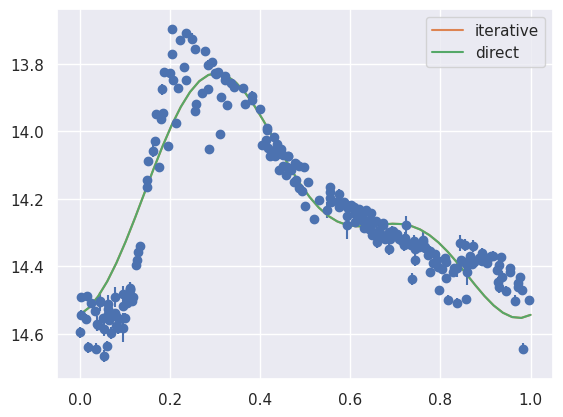

In [12]:
# Part 3:
theta_fit2 = fourier_solve(t, y, dy, 5)

plt.errorbar(t % 1, y, dy, fmt='o')
plt.plot(phase_fit, model(theta_fit, phase_fit), label='iterative');
plt.plot(phase_fit, model(theta_fit2, phase_fit), label='direct');
plt.gca().invert_yaxis()
plt.legend();

## Part II: Bonus – finding the optimal phase

It's possible (though much more difficult) to use maximum-likelihood estimation to find the best phase. Loading the data this way gives the raw MJD values of the observations.

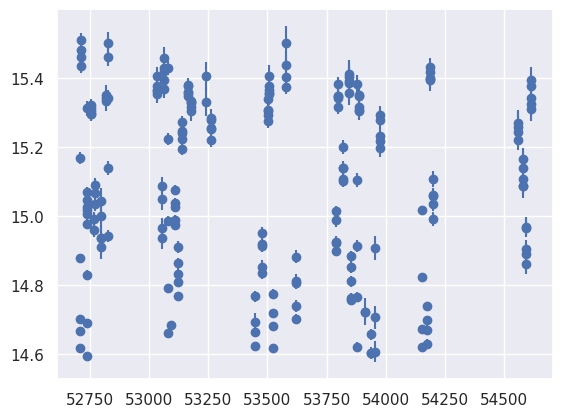

In [13]:
t, y, dy = sample_light_curve(phased=False)
plt.errorbar(t, y, dy, fmt='o');

The model we want to fit is:

$$
y = a_0 + a_1\sin(\omega t) + b_1\cos(\omega t)
$$

except this time our parameter vector is $\theta = [a_0, a_1, a_2, \omega]$. Since we're fitting for $\omega$ itself, this is **not a linear model**, so the closed-form solution will not work. Furthermore, this is a **non-convex** problem, so standard optimization will not work either!

Instead, we'll do a bit of a hack: for each value of $\omega$, we find the best $(a_0, a_1, b_1)$, and then report the value of the log-likelihood as a function of $\omega$.

Your task is to plot $\omega$ vs. $\log L_{max}(\omega)$ and find the $\omega$ which best-fits the data. Once you've done this, divide *t* by the phase, and re-produce the plots you did above.

We'll see later in the week that there is a more efficient way of doing this procedure, called the *Lomb-Scargle Periodogram*. At its core, however, it's essentially doing exactly what we do here, just much more efficiently.

### Solution:

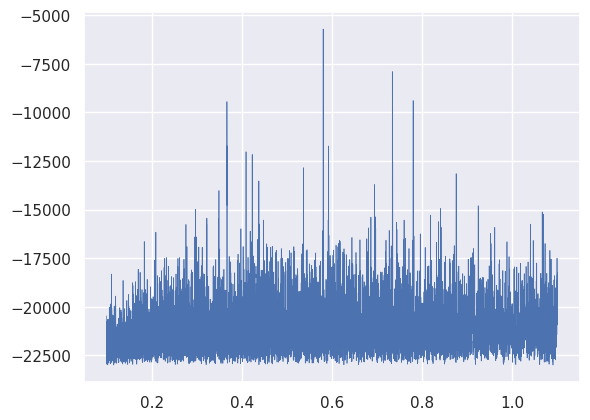

In [14]:
t, y, dy = sample_light_curve(phased=False)

period = np.linspace(0.1, 1.1, 10000)
omega = 2 * np.pi / period
log_like = np.zeros_like(omega)

for i in range(len(omega)):
    theta_fit = fourier_solve(t, y, dy, nterms=5, omega=omega[i])
    log_like[i] = log_likelihood(theta_fit, t, y, dy, omega=omega[i])
    
plt.plot(period, log_like, linewidth=0.5);

See why this can't be iteratively optimized? There are **way** too many local extrema! Let's find the best period:

In [15]:
best_period = period[np.argmax(log_like)]
print(best_period)

0.5803480348034804


Just to make sure, let's zoom-in and get a more precise value for the maximum:

0.5803175317531752


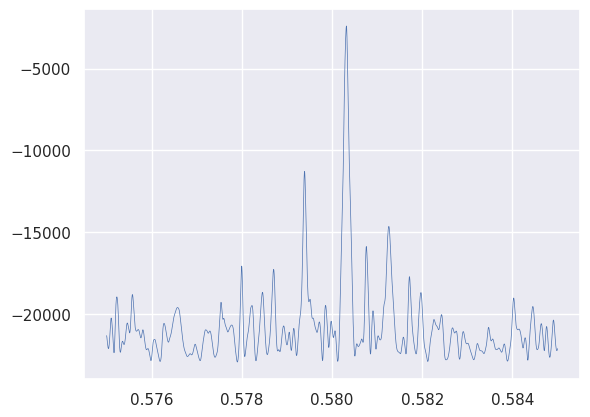

In [16]:
# Zoom-in on this value and find a more precise result

period = np.linspace(0.575, 0.585, 10000)
omega = 2 * np.pi / period
log_like = np.zeros_like(omega)

for i in range(len(omega)):
    theta_fit = fourier_solve(t, y, dy, nterms=5, omega=omega[i])
    log_like[i] = log_likelihood(theta_fit, t, y, dy, omega=omega[i])
    
plt.plot(period, log_like, linewidth=0.5)
    
best_period = period[np.argmax(log_like)]
print(best_period)

Now given this period, let's compute the phase and plot the folded light curve:

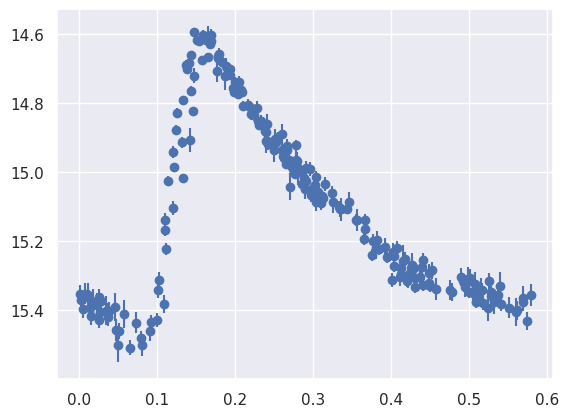

In [17]:
phase = t % best_period
plt.errorbar(phase, y, dy, fmt='o')
plt.gca().invert_yaxis();

We've managed to find the period associated with the maximum likelihood!